In [1]:
from deep_perm_imp import ImagePermI
import skexplain
from skexplain.common.importance_utils import to_skexplain_importance
from sklearn.metrics import average_precision_score
import xarray as xr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

In [2]:
#load in the validation data
examples= xr.load_dataset('/Users/chad.wiley/Documents/2d_models/data_64/full_examples.nc')
channel_names = list(examples.keys())
labels = xr.load_dataset('/Users/chad.wiley/Documents/2d_models/data_64/training_lb.nc')
labels = labels.drop_vars(['dz'])

examples = examples.to_array()
labels = labels.to_array()

examples = examples.transpose("n_samples",...)
examples = examples.transpose(..., "variable")

labels = labels.transpose("n_samples",...)
labels = labels.transpose(..., "variable")

examples = examples.to_numpy()
labels = labels.to_numpy()
labels_flat = labels.flatten()

In [3]:
print(np.shape(examples))
print(np.shape(labels))
print(channel_names)


(16935, 64, 64, 14)
(16935, 64, 64, 1)
['comp_dz_max_norm', 'comp_dz_90_norm', 'comp_dz_avg_norm', 'w_up_max_norm', 'w_up_90_norm', 'w_up_avg_norm', 'w_down_max_norm', 'w_down_90_norm', 'w_down_avg_norm', 'cape_ml_avg_norm', 'cape_sfc_avg_norm', 'cin_ml_avg_norm', 'cin_sfc_avg_norm', 'mrms_norm']


In [4]:
#load in models
model_wbc = tf.keras.models.load_model('/Users/chad.wiley/Documents/2d_models/models/model_64x64_1.h5',compile=False) #WBC
model_wbc_pad = tf.keras.models.load_model('/Users/chad.wiley/Documents/AMS_2022/models/77model.h5',compile=False) #WBC padding
model_wbc_maxfilter_5 = tf.keras.models.load_model('/Users/chad.wiley/Documents/2d_models/models/wbc_maxfilter_5.h5',compile=False)

2023-06-14 20:31:26.958753: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
subsample_size=0.20

ip = ImagePermI(images=examples, model=model_wbc,labels=labels, subsample_size=subsample_size)
ip.single_pass(direction='backward', metric='auc')


Shuffling Images, please wait...
done
(13873152,)
(13873152,)


  0%|          | 0/14 [00:00<?, ?it/s]

(13873152,)
(13873152,)


  7%|▋         | 1/14 [00:30<06:30, 30.03s/it]

(13873152,)
(13873152,)


 14%|█▍        | 2/14 [00:57<05:44, 28.69s/it]

(13873152,)
(13873152,)


 21%|██▏       | 3/14 [01:25<05:10, 28.19s/it]

(13873152,)
(13873152,)


 29%|██▊       | 4/14 [01:52<04:36, 27.65s/it]

(13873152,)
(13873152,)


 36%|███▌      | 5/14 [02:18<04:04, 27.16s/it]

(13873152,)
(13873152,)


 43%|████▎     | 6/14 [02:45<03:37, 27.16s/it]

(13873152,)
(13873152,)


 50%|█████     | 7/14 [03:13<03:10, 27.25s/it]

(13873152,)
(13873152,)


 57%|█████▋    | 8/14 [03:40<02:42, 27.15s/it]

(13873152,)
(13873152,)


 64%|██████▍   | 9/14 [04:07<02:16, 27.32s/it]

(13873152,)
(13873152,)


 71%|███████▏  | 10/14 [04:35<01:49, 27.50s/it]

(13873152,)
(13873152,)


 79%|███████▊  | 11/14 [05:02<01:22, 27.45s/it]

(13873152,)
(13873152,)


 86%|████████▌ | 12/14 [05:30<00:54, 27.39s/it]

(13873152,)
(13873152,)


 93%|█████████▎| 13/14 [05:57<00:27, 27.48s/it]

(13873152,)
(13873152,)


100%|██████████| 14/14 [06:24<00:00, 27.50s/it]


In [6]:
# Since we are ranking from high to low, we need to convert the 
# permuted scores into importance scores
imp_scores = ip.start_score - ip.scores

In [7]:
imp_scores

array([4.42713835e-03, 1.74809946e-02, 3.03575897e-02, 8.28746949e-04,
       9.11261549e-05, 2.46170392e-05, 2.60316792e-04, 1.90308633e-04,
       1.64233497e-05, 1.63428398e-04, 6.97674917e-04, 5.44828186e-04,
       4.17701456e-05, 7.03954191e-02])

In [8]:
# We set the method as 'backward_singlepass'. This is an expected name in skexplain and will
# help with the plotting. 

# to_skexplain_importance is expecting the data in 
# following shape (n_features, n_permutes). For this notebook, 
# we only performed one permutation so we need to convert imp scores to (n_features, 1)
results = to_skexplain_importance(
    importances=np.array([imp_scores]).T, 
    estimator_name='CNN', 
    feature_names=channel_names,
    method='backward_singlepass', normalize=False
)

In [9]:
results

<xarray.Dataset>
Dimensions:                            (n_vars_backward_singlepass: 14,
                                        n_bootstrap: 1)
Dimensions without coordinates: n_vars_backward_singlepass, n_bootstrap
Data variables:
    backward_singlepass_rankings__CNN  (n_vars_backward_singlepass) <U17 'mrm...
    backward_singlepass_scores__CNN    (n_vars_backward_singlepass, n_bootstrap) float64 ...
Attributes:
    estimators used:   CNN
    estimator output:  probability

In [10]:
ratings = ['MRMS Comp. Reflectivity', 'WoFS Ens. Avg. Comp. Reflectivity','WoFS Ens. 90th Percentile Comp. Reflectivity',
           'WoFS Ens. Maximum Comp. Reflectivity', 'WoFS Ens. Maximum Updraft Velocity', 'WoFS Ens. Avg. SFC CAPE',
           'WoFS Ens. Avg. ML CIN', 'WoFS Ens. Maximum Downdraft Velocity','Ens. 10th Percentile Downdraft Velocity',
           'Ens. Avg. ML CAPE', 'Ens. 90th Percentile Updraft Velocity', 'Ens. Avg. SFC CIN',
           'Ens. Avg. Updraft Velocity', 'Ens. Avg. Downdraft Velocity'
]

print(np.shape(ratings))

(14,)


In [ ]:
# np.shape(results['backward_singlepass_scores__CNN'])
# print(results['backward_singlepass_scores__CNN'])

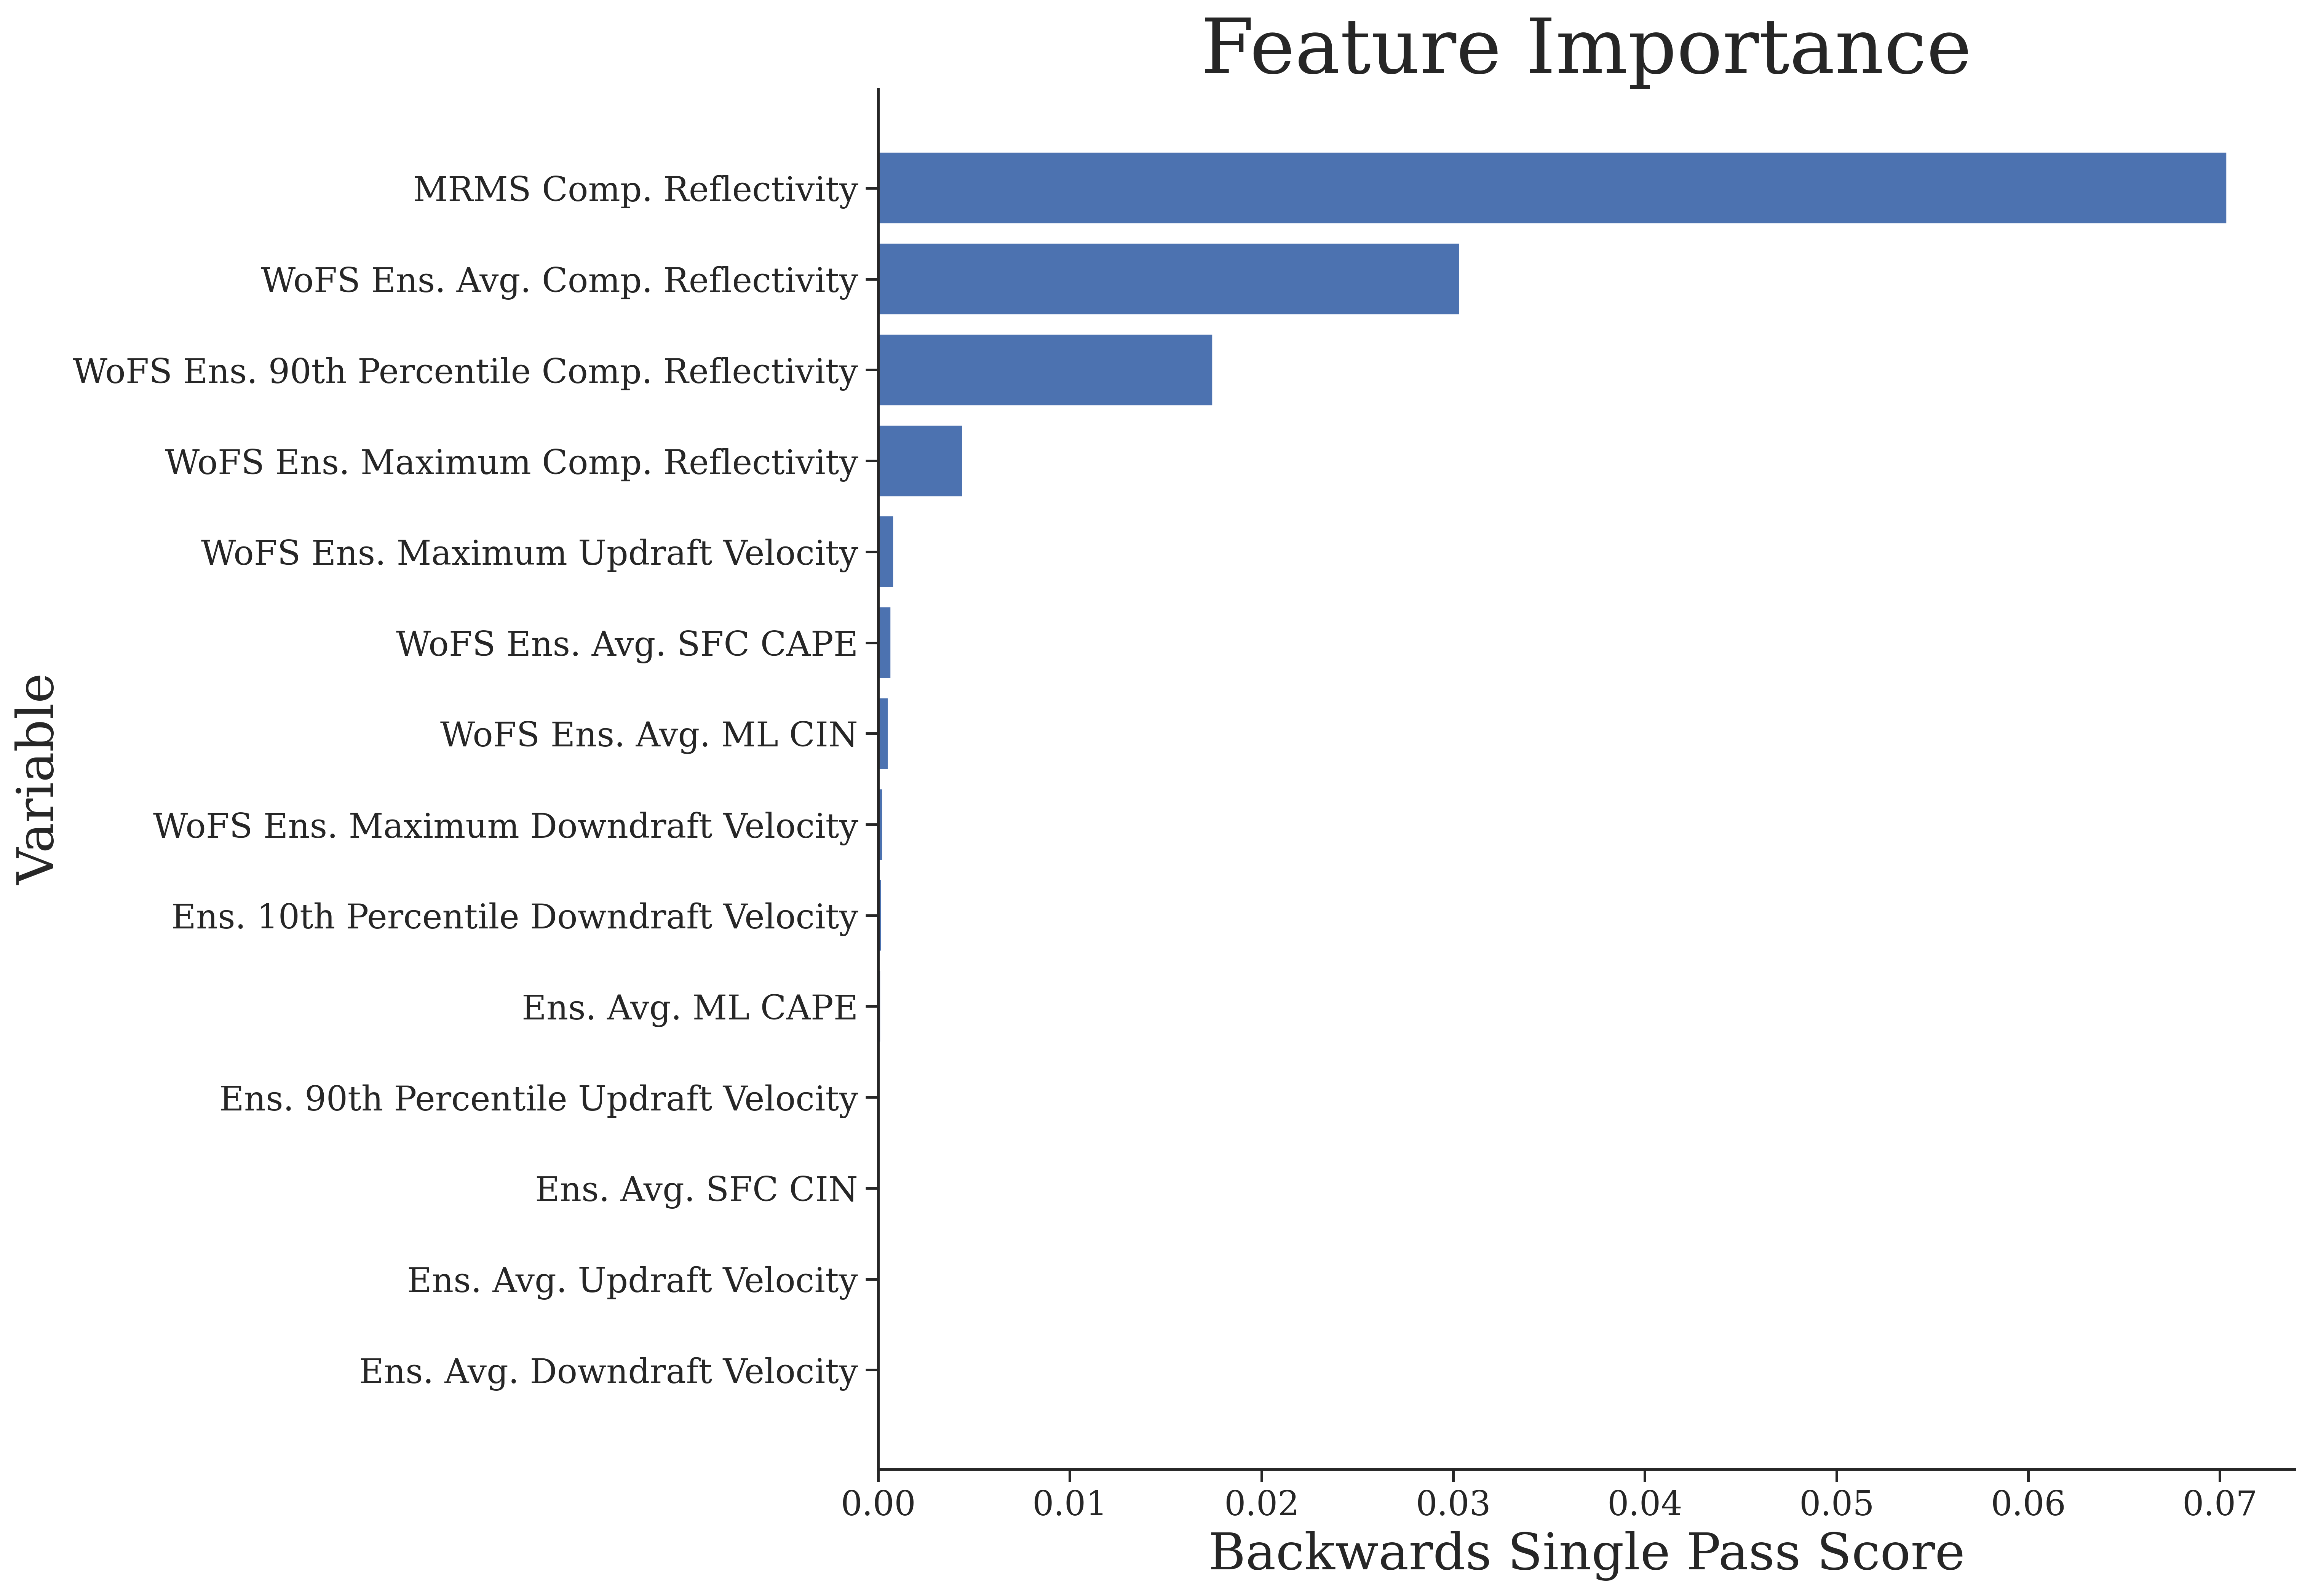

In [13]:
fig, ax = plt.subplots(figsize=(12,12), dpi = 400,
                            nrows = 1, ncols = 1)
ax.barh(ratings,results['backward_singlepass_scores__CNN'][:,0])
ax.set_title("Feature Importance", size = 36)
ax.set_xlabel('Backwards Single Pass Score',size=24)
ax.set_ylabel('Variables',size=24)
ax.tick_params(axis='both', labelsize=16)
# ax.set_xlim([0,.1])

# for i, v in enumerate(results['backward_singlepass_rankings__CNN'],results['backward_singlepass_scores__CNN'][:,0]):
# ax.text(v+.01 , i + .1, str(v), color='blue', fontweight='bold')
plt.gca().invert_yaxis()

plt.savefig('/Users/chad.wiley/Documents/Thesis/Figures/feature_importance.png',bbox_inches='tight')

In [ ]:
results['backward_singlepass_rankings__CNN']

In [ ]:
explainer = skexplain.ExplainToolkit()
fig = explainer.plot_importance(data=results, 
                                panels=[('backward_singlepass', 'Random Forest')], 
                                num_vars_to_plot=15, 
                                 )